<a href="https://colab.research.google.com/github/Arunkumar027/Crop-disease-prediction/blob/main/Crop_disease_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/kaggle"

In [ ]:
!kaggle datasets download -d emmarex/plantdisease

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 98% 643M/658M [00:04<00:00, 186MB/s]
100% 658M/658M [00:04<00:00, 156MB/s]


In [ ]:
!unzip plantdisease.zip -d plant_disease_data

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from timm import create_model
import os

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
# Dataset transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
from torch.utils.data import random_split


dataset_dir = 'plant_disease_data/PlantVillage'

# Load the entire dataset
full_dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)

# Split into train (80%) and test (20%)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

In [ ]:
# DataLoaders for batching
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [ ]:
import os
print(os.getcwd())
print(os.listdir('plant_disease_data/PlantVillage'))

/content
['Tomato_Early_blight', 'Pepper__bell___Bacterial_spot', 'Tomato_Late_blight', 'Potato___Late_blight', 'Tomato_Septoria_leaf_spot', 'Tomato__Target_Spot', 'Potato___Early_blight', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Leaf_Mold', 'Tomato__Tomato_mosaic_virus', 'Pepper__bell___healthy', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_healthy']


In [ ]:
# Load the Vision Transformer model using the original dataset to get the number of classes
model = create_model('vit_base_patch16_224', pretrained=True, num_classes=len(full_dataset.classes))
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

/content
['Tomato_Early_blight', 'Pepper__bell___Bacterial_spot', 'Tomato_Late_blight', 'Potato___Late_blight', 'Tomato_Septoria_leaf_spot', 'Tomato__Target_Spot', 'Potato___Early_blight', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Leaf_Mold', 'Tomato__Tomato_mosaic_virus', 'Pepper__bell___healthy', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_healthy']

In [ ]:

for param in model.parameters():
    param.requires_grad = False

In [ ]:

for param in model.head.parameters():
    param.requires_grad = True

In [ ]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

In [ ]:
# Fine-tuning the model
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%')

Epoch [1/5], Loss: 0.0614, Accuracy: 98.30%
Epoch [2/5], Loss: 0.0317, Accuracy: 99.16%
Epoch [3/5], Loss: 0.0265, Accuracy: 99.35%
Epoch [4/5], Loss: 0.0229, Accuracy: 99.44%
Epoch [5/5], Loss: 0.0203, Accuracy: 99.50%


In [ ]:
#Testing the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 99.03%


In [ ]:
# Save the  model
torch.save(model.state_dict(), 'vit_plantvillage_finetuned.pth')

In [ ]:
import cv2
import torch
from torchvision import transforms
from timm import create_model
from PIL import Image


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load  Vision Transformer model
model = create_model('vit_base_patch16_224', pretrained=False, num_classes=15)
model.load_state_dict(torch.load('vit_plantvillage_finetuned.pth', weights_only=True))  # Updated to weights_only
model = model.to(device)
model.eval()

# Define the image transformations for input into the model
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



# analyze real-time images from a video stream
def real_time_crop_monitoring():

    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print("Error: Could not open video stream.")
        return

    while True:

        ret, frame = cap.read()
        if not ret:
            print("Error: Could not read frame.")
            break


        pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))


        input_image = transform(pil_image).unsqueeze(0).to(device)


        with torch.no_grad():
            output = model(input_image)
            _, predicted_class = torch.max(output, 1)
            label = class_labels[predicted_class.item()]


        cv2.putText(frame, f'Prediction: {label}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)


        cv2.imshow('Real-time Crop Monitoring', frame)


        if cv2.waitKey(1) & 0xFF == ord('q'):
            break


    cap.release()
    cv2.destroyAllWindows()

real_time_crop_monitoring()


Error: Could not open video stream.


In [ ]:
import os
import torch
from torchvision import transforms
from timm import create_model
from PIL import Image
import cv2


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load  Vision Transformer model
model = create_model('vit_base_patch16_224', pretrained=False, num_classes=15)
model.load_state_dict(torch.load('vit_plantvillage_finetuned.pth', weights_only=True))
model = model.to(device)
model.eval()

#  image transformations for input into the model
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Class labels
class_labels = ['Tomato_Early_blight', 'Pepper__bell___Bacterial_spot', 'Tomato_Late_blight', 'Potato___Late_blight', 'Tomato_Septoria_leaf_spot', 'Tomato__Target_Spot', 'Potato___Early_blight', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Leaf_Mold', 'Tomato__Tomato_mosaic_virus', 'Pepper__bell___healthy', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_healthy']


def analyze_images_from_directory(image_dir):

    image_files = [f for f in os.listdir(image_dir) if f.endswith(('jpg', 'jpeg', 'png'))]

    for image_file in image_files:

        image_path = os.path.join(image_dir, image_file)


        pil_image = Image.open(image_path).convert('RGB')
        input_image = transform(pil_image).unsqueeze(0).to(device)


        with torch.no_grad():
            output = model(input_image)
            _, predicted_class = torch.max(output, 1)
            label = class_labels[predicted_class.item()]


        cv2_image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)  # Convert PIL image to OpenCV format
        cv2.putText(cv2_image, f'Prediction: {label}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)


        cv2.imshow('Image Analysis', cv2_image)


        if cv2.waitKey(1000) & 0xFF == ord('q'):  # Display each image for 1000 ms (1 second)
            break


    cv2.destroyAllWindows()


image_directory = ''
analyze_images_from_directory(image_directory)


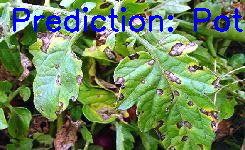

In [ ]:
import cv2
import torch
from torchvision import transforms
from timm import create_model
from PIL import Image
import numpy as np
from google.colab.patches import cv2_imshow

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load  Vision Transformer model
model = create_model('vit_base_patch16_224', pretrained=False, num_classes=15)
model.load_state_dict(torch.load('vit_plantvillage_finetuned.pth', weights_only=True))
model = model.to(device)
model.eval()

# Define the image transformations for input into the model
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Class labels
class_labels = ['Tomato_Early_blight', 'Pepper__bell___Bacterial_spot', 'Tomato_Late_blight', 'Potato___Late_blight', 'Tomato_Septoria_leaf_spot', 'Tomato__Target_Spot', 'Potato___Early_blight', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Leaf_Mold', 'Tomato__Tomato_mosaic_virus', 'Pepper__bell___healthy', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_healthy'] # Updated class_labels to have all the correct labels

# Function to analyze a single image
def analyze_single_image(image_path):
    # Load and preprocess the image
    pil_image = Image.open(image_path).convert('RGB')
    input_image = transform(pil_image).unsqueeze(0).to(device)

    # Predict disease/health condition
    with torch.no_grad():
        output = model(input_image)
        _, predicted_class = torch.max(output, 1)
        label = class_labels[predicted_class.item()]

    # Convert PIL image to OpenCV format for display
    cv2_image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
    cv2.putText(cv2_image, f'Prediction: {label}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)


    cv2_imshow(cv2_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

image_path = '/content/Leafspot2.jpg'
analyze_single_image(image_path)